In [1]:
import pandas as pd #Biblioteca responsavel pela manipulação dos dados
import numpy as np #Biblioteca pra trabalhar com Array e Matriz
import seaborn as sns #Biblioteca de Plot
import matplotlib.pyplot as plt #Tambem uma biblioteca de plot(Trabalha em conjunto com seaborn)

#Vamos vendo com o tempo o que sera usado e descartado, como exemplo vamos deixar esses 3 como principais pra teste de acuracia.
from sklearn.ensemble import RandomForestClassifier #Modelo de Machine Learning - TESTE 1
from sklearn.linear_model import LinearRegression, LogisticRegression #Modelo de Machine Learning - TESTE 2
from sklearn.naive_bayes import MultinomialNB #use to predict

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score #Anda em conjunto com o ML, 3 tipos de métricas para aprendizagem da maquina e testes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

#modelo de seleção
from sklearn.model_selection import train_test_split #Modelo de Machine Learning - TESTE 3

from nltk.tokenize import RegexpTokenizer #split words frin text
from nltk.stem.snowball import SnowballStemmer #stemmes words
from sklearn.feature_extraction.text import CountVectorizer #create sparse matrix of words usind regexp

from sklearn.tree import export_graphviz
import graphviz

from collections import Counter

In [2]:
df = pd.read_csv('malicious_phish.csv') #Coletando o primeiro dataset

In [3]:
df.fillna(df.mode().iloc[0], inplace=True) #substituir os campos nulos por zero
print(df.info()) #conteudo do dataset 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB
None


In [4]:
df.head(10)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [5]:
df.isnull().sum() #mostra os valores nulos no dataset 1

url     0
type    0
dtype: int64

In [6]:
df.describe() #Conteudo do dataset 1: 641.191 dados e 4 tipos de classificação

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


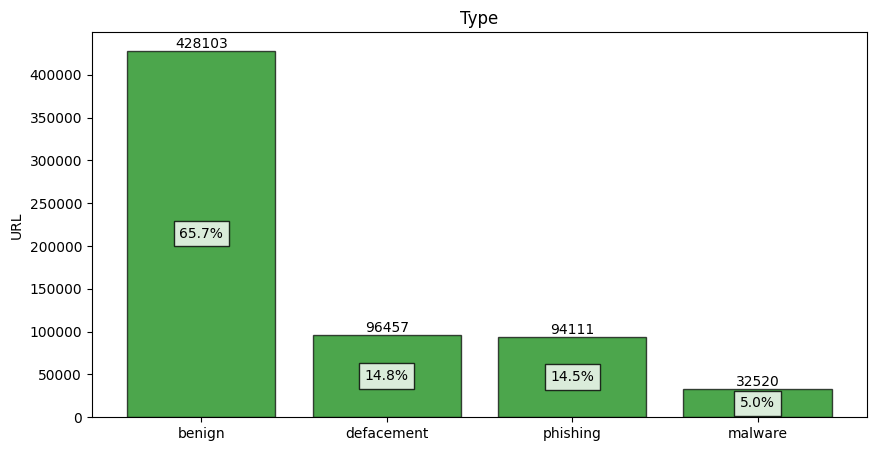

Colunas do dataframe DF Index(['url', 'type'], dtype='object'), 
Valores para ML: type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64, 
Conteúdo: RangeIndex(start=0, stop=651191, step=1)



In [7]:
types = df['type'].values

counter_types = Counter(types)

type_names = list(counter_types.keys())
type_values = list(counter_types.values())

sorted_indices = np.argsort(type_values)[::-1]
type_names = [type_names[i] for i in sorted_indices]
type_values = [type_values[i] for i in sorted_indices]

total_count = sum(type_values)
percentages = [value / total_count * 100 for value in type_values]

pattern = ''

y_pos = np.arange(len(type_names))
plt.figure(1, figsize=(10, 5))
bars = plt.bar(y_pos, type_values, align='center', alpha=0.7, color='green', edgecolor='black', hatch=pattern)

for bar, value, percentage in zip(bars, type_values, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{value}', ha='center', va='bottom')
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{percentage:.1f}%', ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.xticks(y_pos, type_names)
plt.ylabel('URL')
plt.title('Type')
plt.show()

print(f"Colunas do dataframe DF {df.columns}, \nValores para ML: {df['type'].value_counts()}, \nConteúdo: {df.index}\n" )

In [8]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')  #O Tokenizer "corta" uma string usando expressões regulares, cada match que corresponde aos tokens ou aos separadores entre os tokens.

In [9]:
print(df.url[2])

tokenizer.tokenize(df.url[2])

bopsecrets.org/rexroth/cr/1.htm


['bopsecrets', 'org', 'rexroth', 'cr', 'htm']

In [10]:
df['text_tokenized'] = df.url.map(lambda t: tokenizer.tokenize(t))

In [11]:
df.sample(10)

,url,type,text_tokenized
345472,http://www.pubyun.com/blog/deveops/chef-%e8%8a...,malware,"[http, www, pubyun, com, blog, deveops, chef, ..."
399335,caryhomesnc.com/staff.php,benign,"[caryhomesnc, com, staff, php]"
629563,www-306.ibm.com/software/awdtools/fortran/,phishing,"[www, ibm, com, software, awdtools, fortran]"
196632,genforum.genealogy.com/harrison/messages/8333....,benign,"[genforum, genealogy, com, harrison, messages,..."
409411,http://mov-designtec.de/index.php?option=com_c...,defacement,"[http, mov, designtec, de, index, php, option,..."
124183,http://www.guiabella.net/~kayabest/sys/not/521...,phishing,"[http, www, guiabella, net, kayabest, sys, not..."
443925,imdb.com/title/tt0410414/,benign,"[imdb, com, title, tt]"
159395,manta.com/c/mmq3l4y/salon-at-1935,benign,"[manta, com, c, mmq, l, y, salon, at]"
223201,http://www.raci.it/rete-di-vendita/marche.html,defacement,"[http, www, raci, it, rete, di, vendita, march..."
608787,www.yonghuico.com/en/introduce.html,phishing,"[www, yonghuico, com, en, introduce, html]"


In [12]:
stemmer = SnowballStemmer("english")

In [13]:
df['text_stemmed'] = df['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])

In [14]:
df.sample(10)

,url,type,text_tokenized,text_stemmed
215158,http://www.intocht-simpelveld.nl/index.php?opt...,defacement,"[http, www, intocht, simpelveld, nl, index, ph...","[http, www, intocht, simpelveld, nl, index, ph..."
244265,iremove.blogspot.com/,benign,"[iremove, blogspot, com]","[iremov, blogspot, com]"
57160,linkedin.com/pub/andrea-nugent/a/290/6,benign,"[linkedin, com, pub, andrea, nugent, a]","[linkedin, com, pub, andrea, nugent, a]"
420177,http://pastehtml.com/view/bfj6pyjgq.html,phishing,"[http, pastehtml, com, view, bfj, pyjgq, html]","[http, pastehtml, com, view, bfj, pyjgq, html]"
370325,cupinis.com/?page=Media,benign,"[cupinis, com, page, Media]","[cupini, com, page, media]"
563129,gemma-burnham.com/support.account.paypal825_id...,benign,"[gemma, burnham, com, support, account, paypal...","[gemma, burnham, com, support, account, paypal..."
151026,graffitiverite.com/filmmaker.htm,benign,"[graffitiverite, com, filmmaker, htm]","[graffitiverit, com, filmmak, htm]"
58120,nydailynews.com/blogs/nets/2011/07/marshon-bro...,benign,"[nydailynews, com, blogs, nets, marshon, brook...","[nydailynew, com, blog, net, marshon, brook, d..."
577960,xn--c3csr1b9db3h.com/wp-content/uploads/2012/0...,benign,"[xn, c, csr, b, db, h, com, wp, content, uploa...","[xn, c, csr, b, db, h, com, wp, content, uploa..."
386991,http://bodrumdil.com/nglzce.html,defacement,"[http, bodrumdil, com, nglzce, html]","[http, bodrumdil, com, nglzce, html]"


In [15]:
df['text_sent'] = df['text_stemmed'].map(lambda l: ' '.join(l))

In [16]:
df.sample(5)

,url,type,text_tokenized,text_stemmed,text_sent
296347,http://www.timali.com/listings?action=searchre...,defacement,"[http, www, timali, com, listings, action, sea...","[http, www, timali, com, list, action, searchr...",http www timali com list action searchresult s...
369216,soldiergeek.com/milblog/2011/4/24/death-of-the...,benign,"[soldiergeek, com, milblog, death, of, the, ta...","[soldiergeek, com, milblog, death, of, the, ta...",soldiergeek com milblog death of the tank html
518378,crochet.about.com/library/weekly/aa041203b.htm,benign,"[crochet, about, com, library, weekly, aa, b, ...","[crochet, about, com, librari, week, aa, b, htm]",crochet about com librari week aa b htm
45292,http://www.lampao-vc.ac.th/index.php?name=know...,defacement,"[http, www, lampao, vc, ac, th, index, php, na...","[http, www, lampao, vc, ac, th, index, php, na...",http www lampao vc ac th index php name knowle...
216395,en.wikipedia.org/wiki/Interstate_70,benign,"[en, wikipedia, org, wiki, Interstate]","[en, wikipedia, org, wiki, interst]",en wikipedia org wiki interst


In [17]:
CountVectorize = CountVectorizer()

In [18]:
feat = CountVectorize.fit_transform(df.text_sent) #transforma todo o texto que foi stemado e tokenizado

In [19]:
feat[:5].toarray() #convertendo uma matriz sparse para um array para imprimir a variavel feat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [20]:
trainX, testX, trainY, testY = train_test_split(feat, df.type)

In [21]:
#LOGISTIC REGRESSION
lr = LogisticRegression()

lr.fit(trainX,trainY)

C:\Users\leona\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [22]:
lr.score(testX,testY)

0.9513814666027838

[Text(0, 0.5, 'benign'),
 Text(0, 1.5, 'defacement'),
 Text(0, 2.5, 'malware'),
 Text(0, 3.5, 'phishing')]

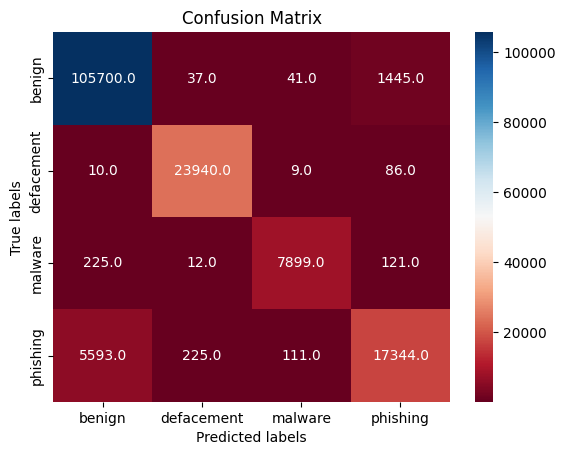

In [23]:
y_pred = lr.predict(testX)
cols = list(lr.classes_)
ax = plt.subplot()
CM_LR = confusion_matrix(testY,y_pred) 
#sns.heatmap(CM_LR, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(CM_LR, annot=True, fmt = ".1f",cmap="RdBu")
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(cols)
ax.yaxis.set_ticklabels(cols)

In [24]:
from sklearn.preprocessing import OneHotEncoder

# Supondo que 'trainY' seja um DataFrame ou Series
one_hot_encoder = OneHotEncoder()
trainY_encoded = one_hot_encoder.fit_transform(trainY.values.reshape(-1,1)).toarray()

In [25]:
reg = LinearRegression()

reg.fit(trainX, trainY_encoded)


LinearRegression()

In [26]:
reg.score(trainX, trainY_encoded)



0.9544369935519095

In [ ]:
rf = decision()

rf.fit (trainX, trainY_encoded)